# DSCI 100 Group Project Proposal: Heart Disease Diagnosis Classification

## 1. Introduction

Heart disease is a term that refers to any condition that affects the function of the heart ( ). As heart disease is the leading cause of death globally, our project aims to consider several risk factors and answer the question, **“Can we predict the diagnosis of heart disease for an individual based on their heart rate, blood pressure, and age?”**

We will answer this question with the help of the Heart Disease Data Set from the UCI Machine Learning Repository. The dataset provides data on an individual’s values for different risk factors including their age, maximum heart rate and blood pressure.

## 2. Preliminary Exploratory Data Analysis
#### Reading the Data

First, we begin by loading the relevant library packages and reading the dataset from the web into R.

In [89]:
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)

options(repr.matrix.max.rows = 6)

In [90]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_data <- read_delim(url,
                         col_names = c("age", "sex", "cp", "trestbps", 
                                         "chol", "fbs", "restecg", "thalach", 
                                         "exang", "oldpeak", "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


*Table 1: Heart Disease Dataset from the Web*

The original dataset was read into R and the columns were renamed to the original attributes listed from the web. The description of each attribute is as follows:

- `age` - Age of the individual (years)
- `sex` - Sex of the individual (1 = male; 0 = female)
- `cp` - Chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4= asymptomatic)
- `trestbps` - Resting blood pressure (mm Hg)
- `chol` - Serum cholestoral (mg/dl)
- `fbs` - If fasting blood sugar is greater than 120 mg/dl (1 = true; 2 = false)
- `restecg` - Resting electrocardiographic results (0 = normal; 1 = abnormal, 2 = hypertrophy)
- `thalach` - Maximum heart rate achieved
- `exang` - Exercise induced angina (1 = yes; 0 = no)
- `oldpeak` - ST depression induced by exercise relative to rest
- `slope` - Slope of the peak exercise ST segment
- `ca` - Number of major vessels (0-3)
- `thal` - Thalassemia (3 = normal; 6 = fixed defect, 7 = reversable)
- `num` - Diagnosis of heart disease (1 = true, 0 = false)

Next, although the dataset is already tidy, we can make a few improvements relevant to our project:
- First, we rename a few important columns with more descriptive titles to provide a clearer understanding of the dataset.
- As the diagnosis column is our target variable for the classification model, we change the data type of the column from double to factor.
- We change the outcome of the diagnosis column from numerical to a yes/no data type for easier comprehension.
- Lastly, we reduce our dataset to contain only the variables we use during our analysis.

Afterwards, we split the data into training and testing sets. Table 2 below shows the training data set that is used for our preliminary data analysis.

In [94]:
# cleaning the data
tidy_heart_data <- heart_data |>
    rename(diagnosis = num,
           max_heart_rate = thalach,
           blood_pressure = trestbps) |>
    mutate(diagnosis = as_factor(diagnosis),
           diagnosis = case_when(diagnosis %in% c(1, 2, 3, 4) ~ "Yes", diagnosis %in% 0 ~ "No")) |>
    select(age, max_heart_rate, blood_pressure, diagnosis)

# splitting the data
heart_split <- initial_split(tidy_heart_data,
                            prop = 0.75,
                            strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

age,max_heart_rate,blood_pressure,diagnosis
<dbl>,<dbl>,<dbl>,<chr>
63,150,145,No
37,187,130,No
41,172,130,No
⋮,⋮,⋮,⋮
45,132,110,Yes
68,141,144,Yes
57,174,130,Yes


*Table 2: Training Data Set*

#### Summary Statistics

To begin exploring our training data, we first check to see if there are any missing values in our dataset.

In [105]:
# check for missing values
missing_values <- data.frame(missing_values = sum(is.na(heart_train)))
missing_values

missing_values
<int>
0


*Table 3: Summary Table on Missing Values in the Data Set*

Next, we find the mean and standard deviation statistics for each predictor.

In [111]:
# mean and standard deviation statistics
mean_and_sd <- heart_train |>
    summarize(mean_age = mean(age, na.rm = TRUE), 
              mean_hr = mean(max_heart_rate, na.rm = TRUE), 
              mean_bp = mean(blood_pressure, na.rm = TRUE),
              sd_age = sd(age, na.rm = TRUE), 
              sd_hr = sd(max_heart_rate, na.rm = TRUE), 
              sd_bp = sd(blood_pressure, na.rm = TRUE))

mean_and_sd

mean_age,mean_hr,mean_bp,sd_age,sd_hr,sd_bp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.12335,149.8238,131.696,9.103764,23.11715,17.74949


*Table 4: Mean & Standard Deviation Statistics for Each Predictor*

#### Visualization

To further explore our data, we create a summary visualization comprised of two scatter plots—one displaying the relationship between age and maximum heart rate, and another displaying the relationship between age and resting blood pressure. Both scatterplots also show if the individual was diagnosed with heart disease through the colour and shape of the data point.

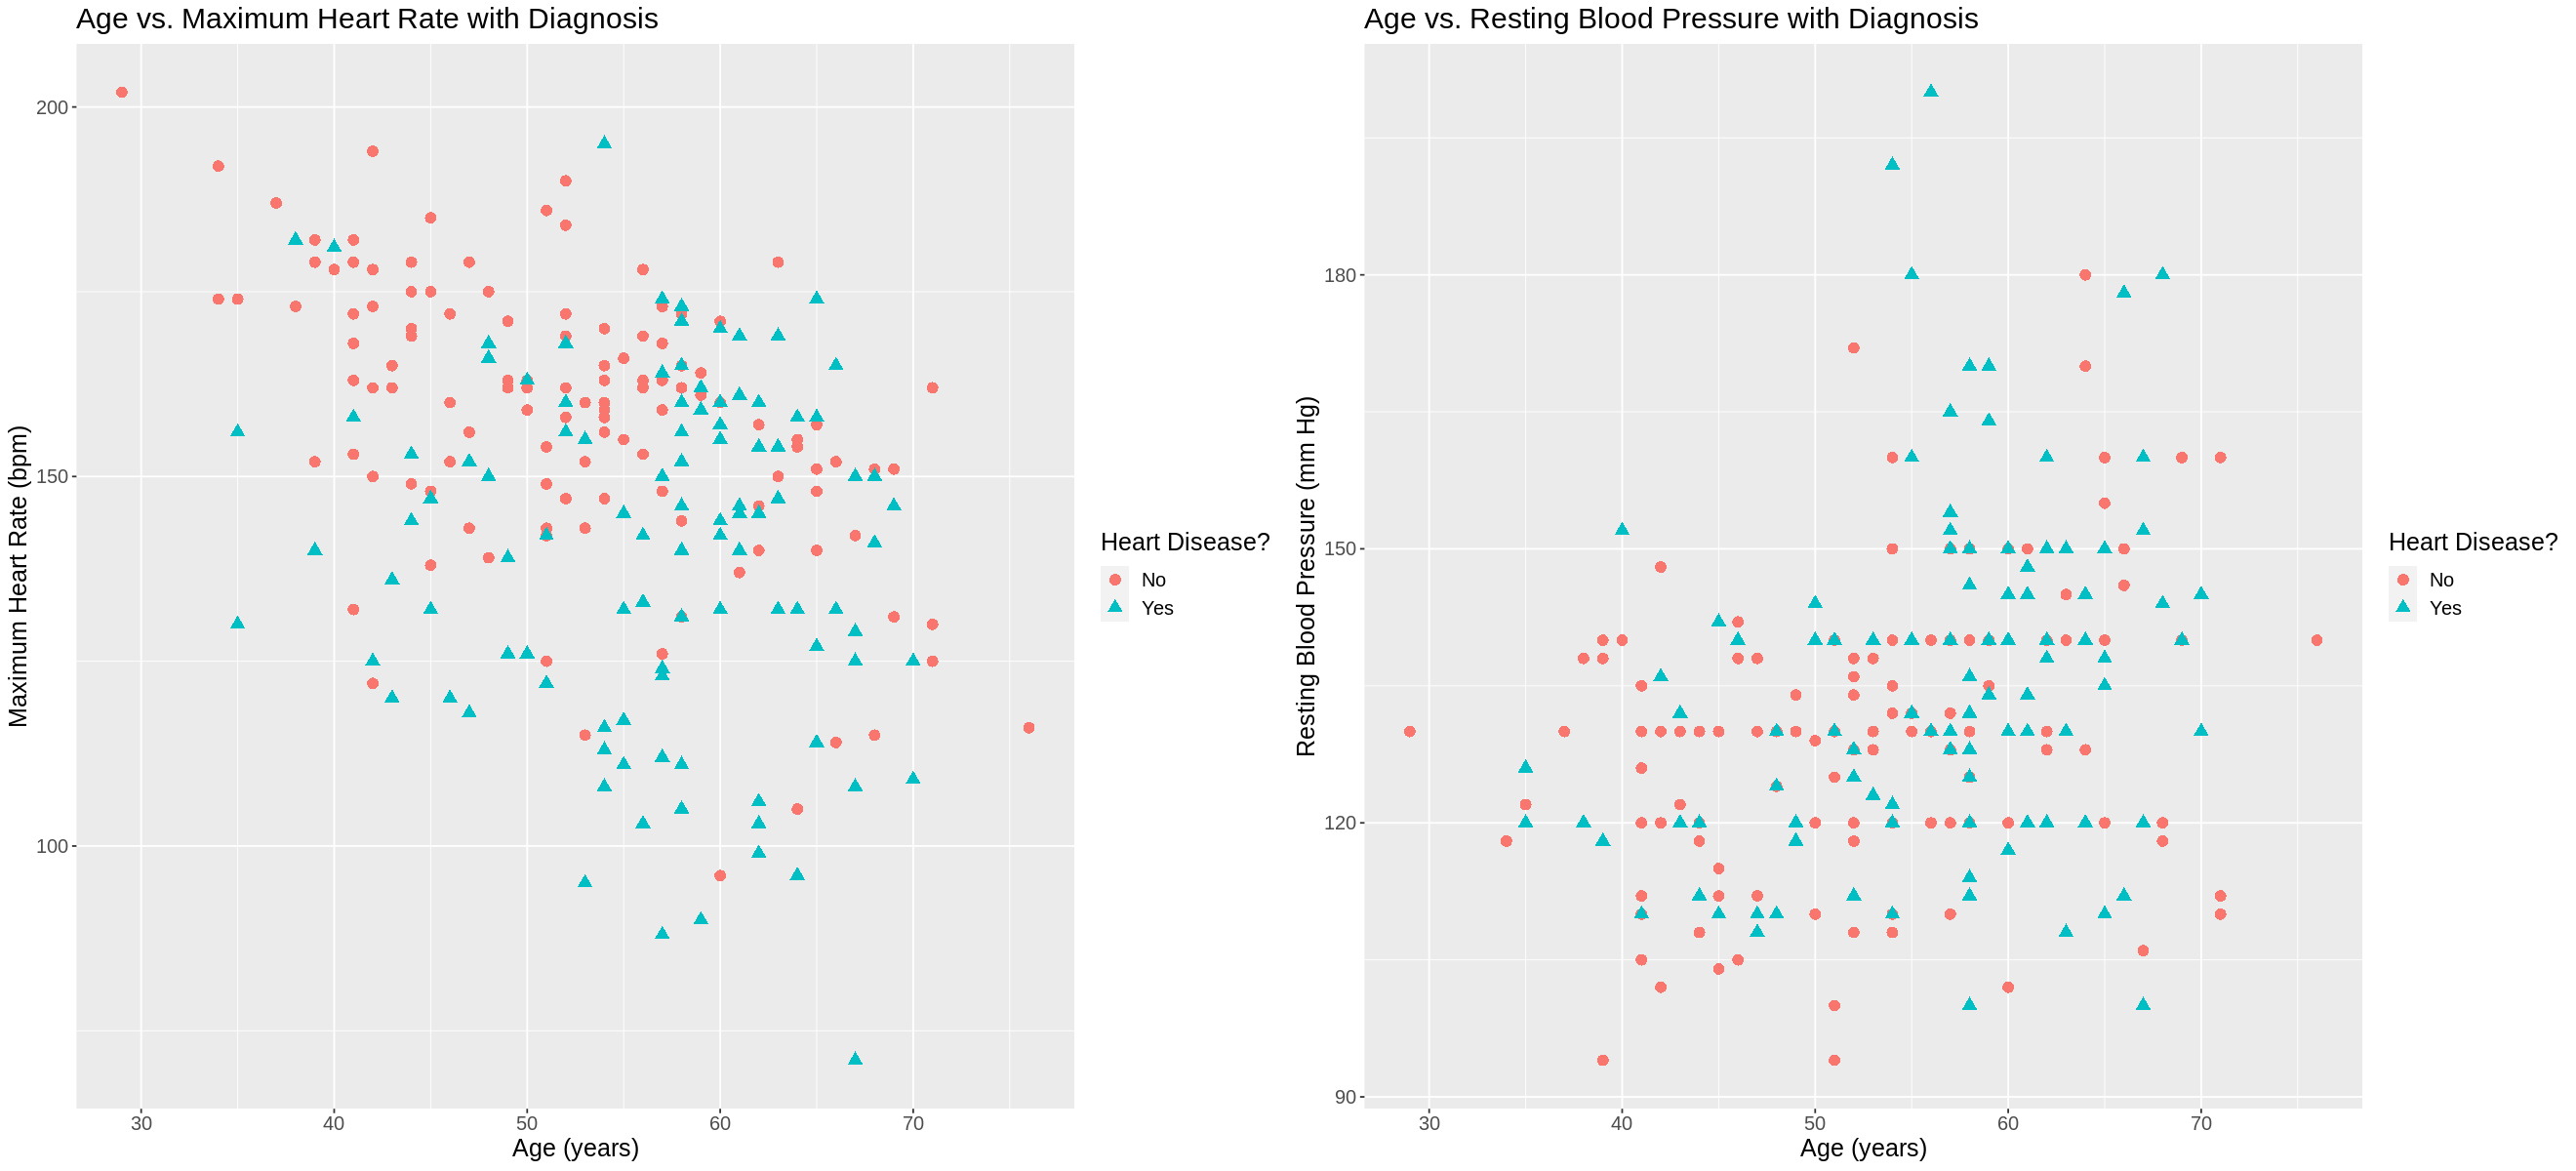

In [112]:
# creating a summary visualization
options(repr.plot.width = 22, repr.plot.height = 10)

age_vs_hr <- heart_train |>
    ggplot(aes(x = age, y = max_heart_rate, color = diagnosis, shape = diagnosis)) +
    geom_point(size = 3) + 
    labs(x = "Age (years)", 
         y = "Maximum Heart Rate (bpm)", 
         color = "Heart Disease?", 
         shape = "Heart Disease?") +
    ggtitle("Age vs. Maximum Heart Rate with Diagnosis") +
    theme(text = element_text(size = 15))

age_vs_bp <- heart_train |>
    ggplot(aes(x = age, y = blood_pressure, color = diagnosis, shape = diagnosis)) +
    geom_point(size = 3) + 
    labs(x = "Age (years)", 
         y = "Resting Blood Pressure (mm Hg)", 
         color = "Heart Disease?", 
         shape = "Heart Disease?") +
    ggtitle("Age vs. Resting Blood Pressure with Diagnosis") +
    theme(text = element_text(size = 15))

plot_grid(age_vs_hr, age_vs_bp,
          label_size = 10)

*Figure 1: Scatterplots of Age vs. Maximum Heart Rate and Age vs. Resting Blood Pressure, with the diagnosis of heart disease shown via shape and colour.*

From Figure 1, we see a weak positive correlation between age and resting blood pressure and a negative correlation between age and heart rate. Additionally, there seems to be more individuals diagnosed with heart disease as age increases. Therefore, our preliminary data analysis can indicate that these three variables may be strong predictors for whether an individual with be diagnosed with heart disease.

## 4. Methods

As we the aim of our project is to create a K-nearest neighbours classification model, we will begin our data analysis by performing a cross validation of five folds to select an optimal K value for our model. For this step, our recipe will include the variables `age`, `blood_pressure`, and `max_heart_rate`, as we would like to explore the relationship between these predictors and an individual's diagnosis of heart disease.

Next, we will build our model and perform a K-nearest neighbour classification with the best k-value found in the previous step. We will use the model to predict observations from our testing data and compare the predictions to the true values in the test set to test the model's accuracy.

Lastly, we will use a confusion matrix to visualize how many observations were correctly predicted.

## 5. Expected Outcome and Significance

## References

Aha, D. W. (1988). Heart Disease Data Set [Data set]. UCI: Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease